In [58]:
import numpy as np
import gensim.downloader as api
import sklearn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [92]:
plt.rcParams["figure.figsize"] = (10, 25)

In [60]:
w2v_model = api.load('word2vec-google-news-300')

In [61]:
guesswordlist_path = 'secretwordlist.txt'
guesswordlistraw = np.loadtxt(guesswordlist_path,'str')
#Consider using a reduced word list when testing for speed
all_words = guesswordlistraw

In [62]:
#Retrieve word vectors
all_vectors = w2v_model[all_words]

In [63]:
#Find n clusters in the word/vector set. Designed to be iterative, so can
#be used to further divide a single cluster
def clusteriseIterative(num_clusters, words, vectors, num_samples = 5):
    kmeans = KMeans(num_clusters).fit(vectors)
    #Cluster size varies so we will break from using numpy
    closest_words = []
    clustered_words = []
    clustered_vectors = []
    
    for i, center in enumerate(kmeans.cluster_centers_):
        words_in_cluster = words[kmeans.labels_==i]
        vectors_in_cluster = vectors[kmeans.labels_==i]
        #Calaculate word closest to the cluster center
        vectors_in_cluster_distance = np.sum((vectors_in_cluster-center)**2,1)
        closest_word = words_in_cluster[np.argmin(vectors_in_cluster_distance)]
        
        closest_words.append(closest_word)
        clustered_words.append(words_in_cluster)
        clustered_vectors.append(vectors_in_cluster)
    
    #Print results
    for i in range(num_clusters):
        sample_index = np.linspace(0,len(clustered_words[i])-1,num_samples,dtype='int')
        sample_words = clustered_words[i][sample_index]
        print('Cluster %s has central word %s. Other words include: %s' % (i,closest_words[i],sample_words))
        
    return clustered_words,clustered_vectors,closest_words

In [90]:
#Visualise the output of the clustering algorithm as a series of flattened
#scatter graphs
def visualiseClusters(words_clusters,vector_clusters,closest_words,num_annotations=20):
    num_clusters = len(words_clusters)
    rows = round(num_clusters/2)
    fig, axs = plt.subplots(rows, 2)
    
    for i in range(num_clusters):
        #Flatten the vectors to a 2D coordinate
        tsne = TSNE(n_components=2,random_state=0)
        new_vectors = tsne.fit_transform(vector_clusters[i])
        #Plot the cluster
        axs[i//2,i%2].scatter(new_vectors[:,0],new_vectors[:,1],alpha=0.2)
        #Sample annotations:
        indices_annotated = np.floor(np.linspace(0,len(words_clusters[i])-1,num_annotations)).astype('int')
        annotated_words = words_clusters[i][indices_annotated]
        annotated_vectors = new_vectors[indices_annotated]
        
        #Remove overlapping annotations
        #We will do this via a mask vector to indicate which labels are overlapping
        #To simplify, we will just check collision on the y axis where label height is fixed
        y_max = np.max(annotated_vectors[:,1])
        y_margin = y_max/10
        
        #True indicates no overlap
        collision_mask = np.ones(num_annotations,dtype='bool')

        for j in range(num_annotations):
            for k in range(num_annotations):
                distance = annotated_vectors[j,1]-annotated_vectors[k,1]
                if (j != k) and (distance >= 0) and (distance < y_margin):
                    collision_mask[j] = False
        
        #Add annotations
        for j in range(num_annotations):
            if collision_mask[j]:
                axs[i//2,i%2].annotate(annotated_words[j],annotated_vectors[j])
        axs[i//2, i%2].set_title("Semantic cluster with center word: %s" % (closest_words[i]))
        axs[i//2, i%2].axis('off')
        
        

In [65]:
a, b, c = clusteriseIterative(10, all_words, all_vectors)

Cluster 0 has central word turn. Other words include: ['boil' 'stay' 'injure' 'wash' 'beat']
Cluster 1 has central word food. Other words include: ['liver' 'toxic' 'salt' 'salad' 'tissue']
Cluster 2 has central word country. Other words include: ['plea' 'holy' 'royal' 'nuclear' 'courtroom']
Cluster 3 has central word but. Other words include: ['most' 'opposite' 'as' 'thus' 'setting']
Cluster 4 has central word person. Other words include: ['executive' 'pastor' 'publisher' 'employer' 'volunteer']
Cluster 5 has central word new. Other words include: ['vital' 'group' 'output' 'consideration' 'seminar']
Cluster 6 has central word inside. Other words include: ['belt' 'bench' 'paint' 'ball' 'beam']
Cluster 7 has central word area. Other words include: ['elevator' 'debris' 'hunting' 'suburb' 'resort']
Cluster 8 has central word just. Other words include: ['forever' 'logic' 'happy' 'anyone' 'laugh']
Cluster 9 has central word see. Other words include: ['consume' 'disturb' 'weigh' 'highlight' '

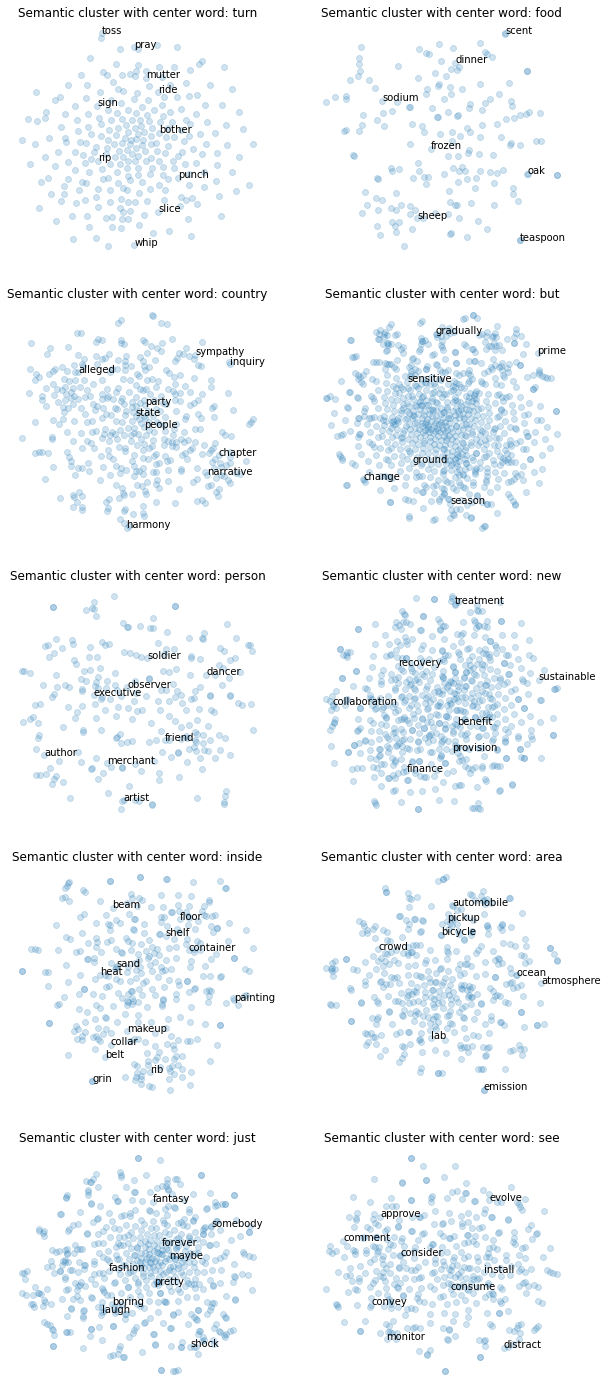

In [93]:
visualiseClusters(a,b,c)